In [134]:
from PIL import Image
from io import BytesIO
from pydicom.encaps import encapsulate
from pydicom.uid import JPEGBaseline, JPEGExtended
from pydicom import dcmread, dcmwrite, Dataset
from pydicom.uid import generate_uid
from pydicom.sequence import Sequence
from pathlib import Path
import numpy as np
import pylibjpeg
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

folder = Path('/home/anvar/work/data/jpeg_dicom_examples/0')

In [253]:
# generate_uid()

# ONLY FOR TESTING PURPOSES

UID = '1.2.826.0.1.3680043.2.1143.6098180853821602296880183626719410063'
# '1.2.826.0.1.3680043.8.498.12477345013628198506379654033510401988'

## gdcmconv

gdcmconv generates correct DICOM. It opens in Weasis with correct color scheme, but not in matplotlib. dunno the reason: tried different color modes (rgb, ybr, ...), it does not help.

In [2]:
!gdcmconv -J --lossy -q 1 -i ../data/jpeg_dicom_examples/0/0.dcm -o ../data/jpeg_dicom_examples/0/0_jpeg.dcm 

You have selected a lossy compression transfer syntax.
This will degrade the quality of your input image, and can.
impact professional interpretation of the image.
Do not use if you do not understand the risk.


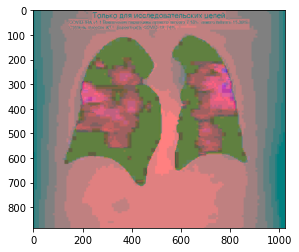

In [4]:
ds_jpeg = dcmread(folder / '0_jpeg.dcm')

plt.imshow(ds_jpeg.pixel_array);

## Compress using PIL

In [28]:
dc = dcmread(folder / '0.dcm')
print(len(dc.PixelData))
px = dc.pixel_array

2715648


In [29]:
im = Image.fromarray(px)
out = BytesIO()
im.save(out, format='jpeg', quality=1)
out.seek(0)

temp = encapsulate([out.getvalue()])
dc.PixelData = temp
dc.file_meta.TransferSyntaxUID = JPEGBaseline
dc['PixelData'].is_undefined_length = True

print(len(out.getvalue()))
print(len(temp))

17947
17968


In [36]:
for key in ds_jpeg.dir():
    try:
        ds_jpeg[key]
        dc[key]
    except Exception as e:
        try:
            print(e)
            print(ds_jpeg[key])
            print('============')
        except Exception as e:
            print(e)
            print('$$$$$$$$$$$$$')

(0008, 9215)
(0008, 9215) Derivation Code Sequence            SQ: <Sequence, length 1>
(0008, 2111)
(0008, 2111) Derivation Description              ST: 'lossy conversion'
(0028, 2110)
(0028, 2110) Lossy Image Compression             CS: '01'
(0028, 2112)
(0028, 2112) Lossy Image Compression Ratio       DS: "151.458337981037"
Unknown Value Representation '0x0a 0x00' in tag (0008, 0005) in tag (0008, 1032)
Unknown Value Representation '0x0a 0x00' in tag (0008, 0005) in tag (0008, 1032)
$$$$$$$$$$$$$
(0008, 2112)
(0008, 2112) Source Image Sequence               SQ: <Sequence, length 1>


In [270]:
def get_compressed_frame(image, quality: int=1, wrap=True):
    im = Image.fromarray(image)
    out = BytesIO()
    im.save(out, format='jpeg', quality=quality)
    out.seek(0)

    if wrap:
        return encapsulate([out.getvalue()])
    return out.getvalue()

def update_tags(ds: Dataset, quality: int=1, compression_ratio:float=None) -> Dataset:
    # 1. TransferSyntaxUID -> JPEGBaseline
    # 2. DerivationDescription -> 'lossy conversion'
    # 3. LossyImageCompression -> '01' - '95'
    # 4. LossyImageCompressionRatio -> Ration between bytes len before and after the compression
    # 5. Derivation Code Sequence # consider add this to generated images
    # 6. Source Image Sequence # consider add this to generated images (currently not in prod)
    # 7. Change SOPInstanceUID
    # 8. ImageType -> ORIGINAL -> DERIVED, btw, better change this for generated images also!
    # 
    
    ds['PixelData'].is_undefined_length = True
    ds.file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.4.50' # JPEGBaseline
    ds.DerivationDescription = 'lossy conversion'
    ds.LossyImageCompression = str(quality).zfill(2)
    ds.LossyImageCompressionRatio = str(compression_ratio)
    
    derivation_code_sequence = Sequence()
    dataset = Dataset()
    dataset.CodeValue = '113040'
    dataset.CodingSchemeDesignator = 'DCM'
    dataset.CodeMeaning = 'Lossy Compression'
    derivation_code_sequence.append(dataset)
    ds.DerivationCodeSequence = derivation_code_sequence
    
    source_image_sequence = Sequence()
    dataset = Dataset()
    dataset.ReferencedSOPClassUID = ds.SOPClassUID # CT Image Storage = '1.2.840.10008.5.1.4.1.1.2'
    dataset.ReferencedSOPInstanceUID = ds.SOPInstanceUID

    purpose_of_reference_code_sequence = Sequence()
    sub_dataset = Dataset()
    sub_dataset.CodeValue = '121320'
    sub_dataset.CodingSchemeDesignator = 'DCM'
    sub_dataset.CodeMeaning = 'Uncompressed predecessor'
    purpose_of_reference_code_sequence.append(sub_dataset)

    dataset.PurposeOfReferenceCodeSequence = purpose_of_reference_code_sequence
    source_image_sequence.append(dataset)
    ds.SourceImageSequence = source_image_sequence
    
    ds.SOPInstanceUID = UID # ONLY FOR TESTING PURPOSES, PUT `generate_uid()` for production
    ds.file_meta.MediaStorageSOPInstanceUID = UID # ONLY FOR TESTING PURPOSES, PUT `generate_uid()` for production
    
    ds.ImageType[0] = 'DERIVED '
    return ds

def compress_dicom(ds: Dataset, quality: int=1) -> Dataset:
    image_size = len(ds.PixelData)
    jpeg_frame = get_compressed_frame(ds.pixel_array, quality=quality)
    compression_ratio = image_size / len(jpeg_frame)
    ds.PixelData = jpeg_frame
    return update_tags(ds, quality, compression_ratio)

In [271]:
ds_jpeg = dcmread(folder / '0_jpeg.dcm')
dc = dcmread(folder / '0.dcm')
# dc.IconImageSequence[0].PlanarConfiguration = 0

del dc['IconImageSequence']
del ds_jpeg['IconImageSequence']
print(len(dc.PixelData))
px = dc.pixel_array

2715648


In [272]:
dc = compress_dicom(dc, 1)

In [273]:
# dc.PixelData = ds_jpeg.PixelData
# dc.PixelData == ds_jpeg.PixelData

In [274]:
dcmwrite(folder / '0_jpeg_pil_1.dcm', dc, write_like_original=False)

In [259]:
for key in ds_jpeg.dir():
    try:
        if ds_jpeg[key] != dc[key]:
            print(key)
    except Exception as e:
        try:
            print(e)
            print(ds_jpeg[key])
            print('============')
        except Exception as e:
            print(e)
            print('$$$$$$$$$$$$$')
    

LossyImageCompressionRatio
PerformedProtocolCodeSequence
PixelData
Unknown Value Representation '0x0a 0x00' in tag (0008, 0005) in tag (0008, 1032)
Unknown Value Representation '0x0a 0x00' in tag (0008, 0005) in tag (0008, 1032)
$$$$$$$$$$$$$
ReferencedPerformedProcedureStepSequence
ReferencedStudySequence


In [292]:
del ds_jpeg[('0008', '1032')]
del ds_jpeg['ReferencedPerformedProcedureStepSequence']
del ds_jpeg['ReferencedStudySequence']
del ds_jpeg['PerformedProtocolCodeSequence']

In [293]:
for key in ds_jpeg.dir():
    try:
        if ds_jpeg[key] != dc[key]:
            print(key)
    except Exception as e:
        try:
            print(e)
            print(ds_jpeg[key])
            print('============')
        except Exception as e:
            print(e)
            print('$$$$$$$$$$$$$')


LossyImageCompressionRatio
PixelData


In [296]:
for key in dc.dir():
    try:
        if ds_jpeg[key] != dc[key]:
            print(key)
    except Exception as e:
        try:
            print(e)
            print(dc[key])
            print('============')
        except Exception as e:
            print(e)
            print('$$$$$$$$$$$$$')


LossyImageCompressionRatio
(0040, 0260)
(0040, 0260) Performed Protocol Code Sequence    SQ: <Sequence, length 1>
PixelData
(0008, 1032)
(0008, 1032) Procedure Code Sequence             SQ: <Sequence, length 1>
(0008, 1111)
(0008, 1111) Referenced Performed Procedure Step SQ: <Sequence, length 1>
(0008, 1110)
(0008, 1110) Referenced Study Sequence           SQ: <Sequence, length 1>


In [298]:
dc.PerformedProtocolCodeSequence[0]

(0008, 0100) Code Value                          SH: 'A06.09.005'
(0008, 0102) Coding Scheme Designator            SH: 'AGFA'
(0008, 0104) Code Meaning                        LO: 'KOMP`YUTERNAYA TOMOGRAFIYA ORGANOV GRUDNOY POLOSTI'

In [299]:
dc.ProcedureCodeSequence[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0100) Code Value                          SH: 'A06.09.005'
(0008, 0102) Coding Scheme Designator            SH: 'AGFA'
(0008, 0104) Code Meaning                        LO: 'CODE MEANING'

In [302]:
dc[('0008', '1111')][0]

(0008, 1150) Referenced SOP Class UID            UI: Modality Performed Procedure Step SOP Class
(0008, 1155) Referenced SOP Instance UID         UI: 1.2.40.0.13.1.115894581115941754948769215369004653306

In [303]:
dc.ReferencedStudySequence[0]

(0008, 1150) Referenced SOP Class UID            UI: Detached Study Management SOP Class
(0008, 1155) Referenced SOP Instance UID         UI: 1.2.40.0.13.1.152387396524096515215536600339746331725

In [304]:
dc.file_meta

(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1143.6098180853821602296880183626719410063
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.0.0'

In [294]:
dcmwrite(folder / '0_test.dcm', ds_jpeg, write_like_original=False)